# Projet 7   Implémentez un modèle de scoring

## Part 3 : Select model 

### Import libraries

In [3]:
# builtin
import os,warnings,sys
import time
# data
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy import mean
from datetime import datetime

# visualisation
import matplotlib as mtpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.color_palette("tab10", as_cmap=False)


from sklearn.dummy import DummyClassifier

# sklearn
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_classif,chi2,SelectFromModel
from sklearn.model_selection import (train_test_split ,learning_curve,cross_validate,
                                    GridSearchCV,cross_val_score,RepeatedStratifiedKFold)

from sklearn.metrics import( f1_score,confusion_matrix,classification_report,make_scorer,precision_score,
                            recall_score,precision_recall_fscore_support, ConfusionMatrixDisplay,
                            roc_auc_score, roc_curve,accuracy_score,get_scorer_names,fbeta_score,
                           )

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC

#yellowbrick
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ClassificationReport,ROCAUC, PrecisionRecallCurve

# scipy
from scipy.stats import kstest,stats,norm,chi2_contingency

#feature_engine
from feature_engine.selection import SmartCorrelatedSelection,DropConstantFeatures

#imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE,BorderlineSMOTE, SVMSMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from imblearn.metrics import classification_report_imbalanced

#LGBM
from lightgbm import LGBMClassifier

#XGBOOST
from xgboost import XGBClassifier

#joblist
from joblib import dump, load

from pprint import pprint

plt.rcParams["figure.figsize"] = 8, 4
%matplotlib inline
sns.set_style("ticks")
sns.color_palette("tab10", as_cmap=False)
pd.set_option('display.float_format', '{:,.4f}'.format)
# pour ne pas imprimer les warnings
warnings.filterwarnings('ignore')

In [4]:
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

In [5]:
@timeit
def classification(model,name,X_train,y_train):
   
    scoring = {'f1': 'f1','roc_auc':'roc_auc','accuracy':'accuracy',
               'fbeta' : make_scorer(custom_score)}
    score = cross_validate(model,X_train,y_train,cv=10, scoring = scoring, return_train_score = True)
    
    dico = {
        'modèle ': [name],
        'Fit time': [score['fit_time'].mean()],
        'Durée': [score['score_time'].mean()],
        'Train F1': [score['train_f1'].mean()],
        'Test F1':[score['test_f1'].mean()],
        'Train FBETA': [score['train_fbeta'].mean()],
        'Test FBETA': [score['test_fbeta'].mean()],
        'Train ROC_AUC':[score['train_roc_auc'].mean()],
        'Test ROC_AUC': [score['test_roc_auc'].mean()],
        'Train ACCURACY':[score['train_accuracy'].mean()],
        'Test ACCURACY':[score['test_accuracy'].mean()],
         }
    df_dico = pd.DataFrame(dico)
    
    return df_dico

In [6]:
# Define the custom scoring function
def custom_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)


In [7]:
@timeit
def compare_resultat(X_train,y_train):
    resultats = pd.DataFrame()
    model =[]
    model.append(('Dummy_Classifier',DummyClassifier()))
    model.append(('Logistic_Regression', LogisticRegression()))
    model.append(('Decision_Tree_Classifier', DecisionTreeClassifier(random_state=seed)))
    model.append(('Random_forest Classifier', RandomForestClassifier(random_state=seed)))
    model.append(('Bagging Classifier',BaggingClassifier(random_state=seed)))
    model.append(('Linear_SVC',LinearSVC(random_state=seed)))
    model.append(('XGB_Classifier', XGBClassifier())),
    model.append(('Gradient_Boosting_Classifier',GradientBoostingClassifier(random_state=seed)))
    model.append(('LGBM-Classifier',LGBMClassifier()))
       
    for name, mod in model: 
        clf = classification(mod, name,X_train,y_train)
        resultats = pd.concat([resultats,clf], ignore_index=True)
        
    return resultats.style.hide_index()

In [8]:
@timeit
def compare_resultat2(X_train,y_train):
    resultats2 = pd.DataFrame()
    model =[]
    model.append(('Dummy_Classifier_balanced',DummyClassifier()))
    model.append(('Logistic_Regression_balanced', LogisticRegression(class_weight='balanced')))
    model.append(('Decision_Tree_Classifier_balanced', DecisionTreeClassifier(random_state=seed,class_weight='balanced')))
    model.append(('Random_forest Classifier_balanced', RandomForestClassifier(random_state=seed,class_weight='balanced')))
    model.append(('Bagging Classifier_balanced',BaggingClassifier(random_state=seed)))
    model.append(('Linear_SVC_balanced',LinearSVC(random_state=seed,class_weight='balanced')))
    model.append(('XGB_Classifier_balanced', XGBClassifier(scale_pos_weight=99))),
    model.append(('Gradient_Boosting_Classifier_balanced',GradientBoostingClassifier(random_state=seed)))
    model.append(('LGBM_Classifier_balanced',  LGBMClassifier(class_weight='balanced')))
       
    for name, mod in model: 
        clf = classification(mod, name,X_train,y_train)
        resultats2 = pd.concat([resultats2,clf], ignore_index=True)
    return resultats2.style.hide_index()

In [9]:
def evaluation(model):
    model.fit(X_train,y_train)
    ypred=model.predict(X_val)
    
    print(confusion_matrix(y_val,ypred))
    print(classification_report(y_val,ypred))
    
    #learning_curve
    N,train_score,val_score=learning_curve(model,X_train,y_train,cv=3,scoring='f1',train_sizes=np.linspace(0.1,1,5))
    
    #affichage
    plt.figure(figsize=(4,4))
    plt.plot(N,train_score.mean(axis=1),label="train score")
    plt.plot(N,val_score.mean(axis=1),label="validation score")
    plt.legend()
    plt.show()

In [10]:
def correlation_matrice(df,corr_method):
    '''
pearson : standard correlation coefficient
kendall : Kendall Tau correlation coefficient
spearman :  Spearman rank correlation
''' 
    
    corr = df.corr(method=corr_method)
    
    mask=np.triu(np.ones_like(corr,dtype=bool))
    sns.heatmap(corr,mask=mask,center=0,cmap='RdBu',linewidths=1,annot=True,fmt='.2f',vmin=-1,vmax=1)
    plt.title('Heatmap des corrélations avec la méthode {}'.format(corr_method),fontsize=14,fontweight="bold")
    plt.show()

### loading data

In [11]:
X_train=pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_train_mod.csv')
X_val=pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_val_mod.csv')
X_test=pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_test_mod.csv')
y_train=pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\y_train_mod.csv')
y_val=pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\y_val_mod.csv')

### Fitting  models

Nous évaluerons les modèles à l'aide d'un Cross_Validate( cv =10)


Prédiction de l'étiquette de classe :  

     . =0  le client n'aura pas de difficultés de paiement 
     . =1  le client aura des difficultés de paiement 


In [13]:
seed=1234
scoring = {'f1': 'f1','roc_auc':'roc_auc','accuracy':'accuracy',
               'fbeta' : make_scorer(custom_score)}

In [ ]:
compare_resultat(X_train,y_train)

**Tableau des résultats**

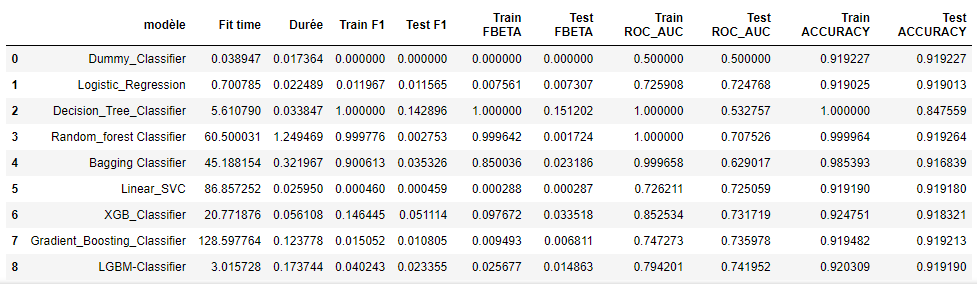

Les résultats sont mauvais quel que soit le modèle. Il est temps de prendre en compte le déséquilibre de classes.

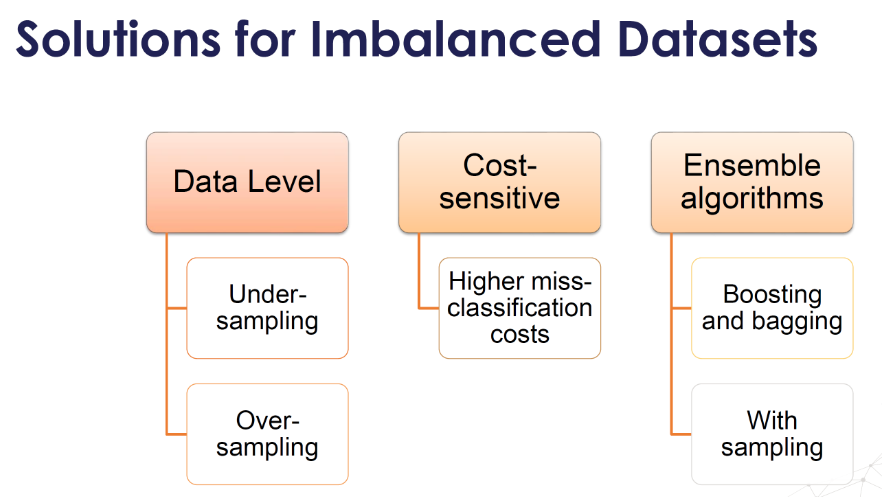

La qualité d'un modèle de classification dépend directement de la métrique utilisée pour l'évaluer.La classification sur données déséquilibrées est un problème de classification où l’échantillon d’apprentissage contient une forte disparité entre les classes à prédire. Ce problème revient fréquemment dans les problèmes de classification binaire, et notamment la détection d’anomalies.

La classification sur données déséquilibrées est un problème de classification où l’échantillon d’apprentissage contient une forte disparité entre les classes à prédire.   Ce problème revient fréquemment dans les problèmes de classification binaire, et notamment la détection d’anomalies.Le choix d’une métrique appropriée est particulièrement difficile pour les problèmes de classification déséquilibrée.

Dans le cas de données comportant une classe fortement majoritaire, les algorithmes classiques sont souvent biaisés car leurs fonctions de perte tentent d’optimiser des métriques telles que le taux de bonnes prédictions, en ne tenant pas compte de la distribution des données.  
Le modèle semblera performant mais cela ne sera que le reflet de la surreprésentation de la classe majoritaire.   
**Dans la majorité des cas, c’est justement la classe minoritaire qui présente le plus fort intérêt** et que l’on aimerait pouvoir identifier, comme dans l’exemple de la détection de fraudes.  
Afin d’évaluer le modèle par rapport au comportement souhaité sur une classe, il est possible d’utiliser une série de métriques issues de la matrice de confusion, comme notamment la précision, le rappel (recall) et le f1-score

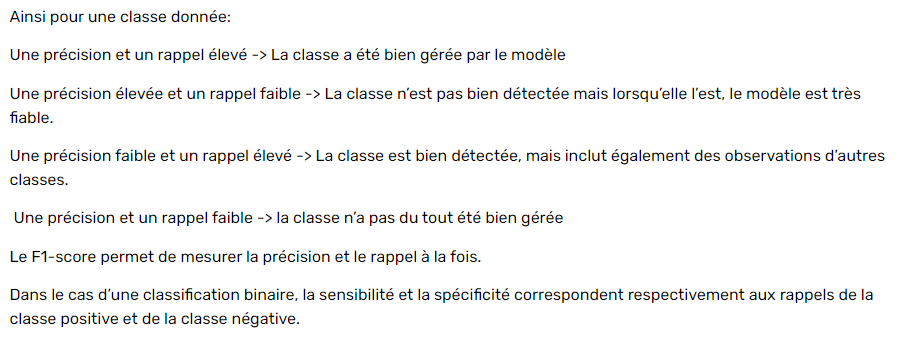

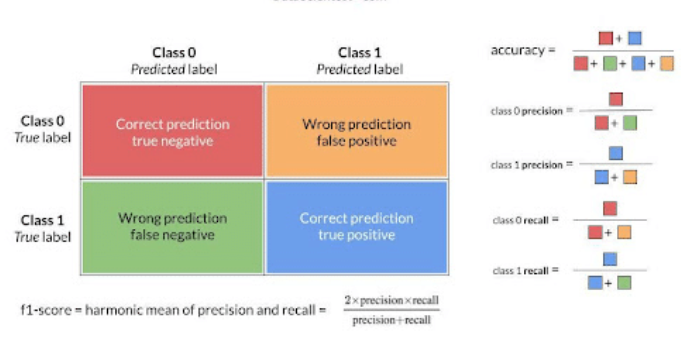

### Balance classes using Cost-Sensitive Learning

Le Cost-Sensitive learning est une méthode des pondérations équilibrées qui ne modifie pas le rapport des classes minoritaires et majoritaires.Il pénalise les mauvaises prédictions sur la classe minoritaire en donnant plus de poids à la fonction de perte.
On attribue des coûts basés sur la distribution inverse des classes.


In [ ]:
compare_resultat2(X_train,y_train)

**Tableau des résultats**

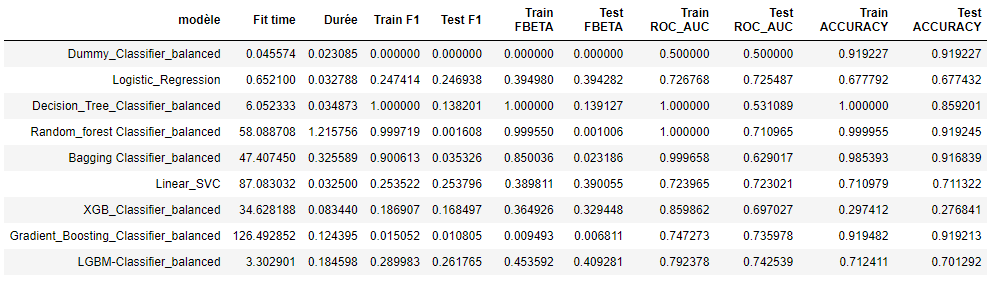

Je conserve uniquement les 4 meilleurs modèles pour affiner les paramètres de class_weight. Il s'agit de :

LGBM_Classifier_balanced Logistic_Regression_balanced linear_SVM_balanced XGB_Classifier_Balanced

In [19]:
# paramètres
seed=1234
lr_param_grid = [{'LR__class_weight': ['balanced',{0: 50, 1: 1},{0: 10, 1: 1}, {0: 1, 1: 10},{0: 1, 1: 50}]}]

#svm_param_grid = [{'SVM__class_weight': ['balanced',{0: 50, 1: 1},{0: 10, 1: 1}, {0: 1, 1: 10},{0: 1, 1: 50}]}]

lgbm_param_grid=[{'LGBM__scale_pos_weight':[99,50,10]}]

xgb_param_grid = [{'XGB__scale_pos_weight': [1, 10, 25, 50, 75, 99,100,1000]}]

#Pipelines
pipe_lgbm = Pipeline([('LGBM', LGBMClassifier(random_state=seed))])

pipe_lr = Pipeline([('LR',LogisticRegression(random_state=seed))])

#pipe_svm = Pipeline([('SVM', SVC(random_state=seed))])

pipe_xgb = Pipeline([('XGB', XGBClassifier(random_state=seed))])

In [20]:
scoring = {'f1': 'f1','roc_auc':'roc_auc','accuracy':'accuracy',
               'fbeta' : make_scorer(custom_score)}

lgbm_grid_search = GridSearchCV(estimator=pipe_lgbm,param_grid=lgbm_param_grid,  scoring='f1',   cv=3)

lr_grid_search = GridSearchCV(estimator=pipe_lr, param_grid=lr_param_grid, scoring='f1', cv=3)

#svm_grid_search = GridSearchCV(estimator=pipe_svm, param_grid=svm_param_grid, scoring='f1', cv=3)

xgb_grid_search = GridSearchCV(estimator=pipe_xgb, param_grid=xgb_param_grid, scoring='f1', cv=3)


In [21]:
grids = [lgbm_grid_search, lr_grid_search, xgb_grid_search]  #, svm_grid_search
for pipe in grids:
    pipe.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11591, number of negative: 131913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3534
[LightGBM] [Info] Number of data points in the train set: 143504, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080771 -> initscore=-2.431914
[LightGBM] [Info] Start training from score -2.431914
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11592, number of negative: 131913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

LightGBM Valid f1: 0.27
LightGBM Best Params: {'LGBM__scale_pos_weight': 10}


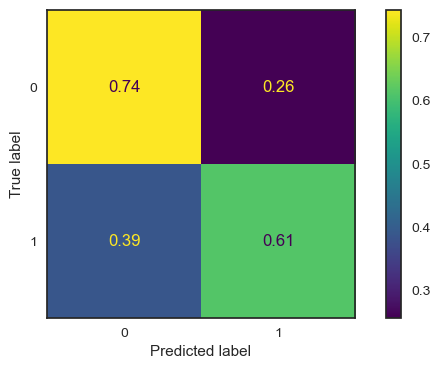

Logistic Regression Valid f1: 0.26
Logistic Regression Best Params: {'LR__class_weight': {0: 1, 1: 10}}


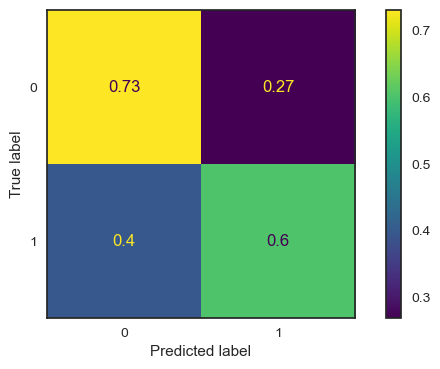

XGBoost Valid f1: 0.27
XGBoost Best Params: {'XGB__scale_pos_weight': 10}


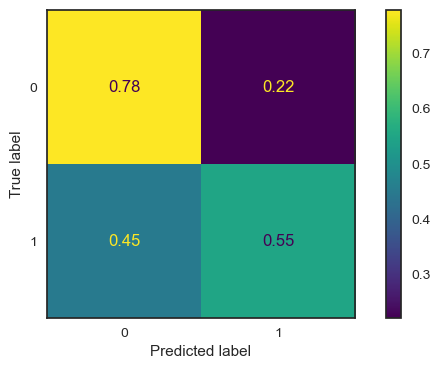

In [23]:

grid_dict = {0: 'LightGBM', 1: 'Logistic Regression', 
              2: 'XGBoost', 
             }
for i, model in enumerate(grids):
    print('{} Valid f1: {:,.2f}'.format(grid_dict[i],
    model.score(X_val,y_val)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
    predictions = model.predict(X_val)
    cm = confusion_matrix(y_val, predictions, labels=model.classes_,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
    disp.plot()

    plt.show()

Le modele Light GBM donne le meilleur résultat avec un temps de calcul très inférieur au temps de calcul du modèle de SVM

### Balance classes with UNDERSAMPLING or OVERSAMPLING methods

In [ ]:
# evaluer le modele

def evaluate_model(X, y, model):
    #  définir procedure evaluation 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
    # définir metrique d'evaluation
    #
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluation modele
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-2)
    return scores

In [ ]:
#modeles d'oversampling et undersampling

def get_models():
    models, names = list(), list()
    
    # RandomOverSampler
    models.append(RandomOverSampler(sampling_strategy='auto', 
                                    random_state=1234))
    names.append('Random_OverSampler')
    
    # SMOTE
    models.append(SMOTE(sampling_strategy='auto',  
                        random_state=1234,  
                        k_neighbors=5,
                        n_jobs=-2))
    names.append('SMOTE')
    return models, names

In [ ]:
#modeles d'oversampling et undersampling

def get_models():
    models, names = list(), list()
    
    # RandomOverSampler
    models.append(RandomOverSampler(sampling_strategy='auto', 
                                    random_state=1234))
    names.append('Random_OverSampler')
    
    # SMOTE
    models.append(SMOTE(sampling_strategy='auto',  
                        random_state=1234,  
                        k_neighbors=5,
                        n_jobs=-2))
    names.append('SMOTE')
    
    # ADASYN
    models.append(ADASYN(sampling_strategy='auto',  
                        random_state=1234,  
                        n_neighbors=5,
                        n_jobs=-2))
    names.append('ADASYN')
    
    # BorderlineSMOTE1
    models.append(BorderlineSMOTE(sampling_strategy='auto', 
                                  random_state=1234,  
                                  k_neighbors=5,
                                  m_neighbors=10,
                                  kind='borderline-1',
                                  ))
    names.append('Borderline_SMOTE1')
   
    # BorderlineSMOTE2
    models.append(BorderlineSMOTE(sampling_strategy='auto', 
                                  random_state=1234,  
                                  k_neighbors=5,
                                  m_neighbors=10,
                                  kind='borderline-2',
                                  ))
    names.append('Borderline_SMOTE2')
    
    #SVMSMOTE
    # models.append(SVMSMOTE(sampling_strategy='auto',  #Variante de l'algorithme SMOTE qui utilise un algorithme SVM                  
    #                             random_state=1234,   #pour détecter l'échantillon à utiliser pour générer de nouveaux                        
    #                             k_neighbors=5,       #échantillons synthétiques  
    #                             m_neighbors=10,
    #                              ))
    #names.append('SVM_SMOTE')     ENLEVE DE LA LISTE CAR TEMPS DE CALCUL TROP IMPORTANT (>24h)
        
    # RandomUnderSampler
    models.append(RandomUnderSampler(sampling_strategy='auto', 
                                    random_state=1234))
    names.append('Random_UnderSampler')
    
    # NEARMISS
    models.append(NearMiss(sampling_strategy='auto',
                           version = 1,
                           n_neighbors=5,
                          ))
    names.append('NEARMISS_1')    #sélectionne les échantillons positifs pour lesquels la distance moyenne 
                                  #aux k échantillons les plus proches de la classe négative est la plus petite.
   
     # NEARMISS
    models.append(NearMiss(sampling_strategy='auto',
                           version = 1,
                           n_neighbors=5,
                          ))
    names.append('NEARMISS_2')    # sélectionne les échantillons positifs pour lesquels la distance moyenne
                                  #aux k échantillons les plus éloignés de la classe négative est la plus petite.
    
    # NEARMISS
    models.append(NearMiss(sampling_strategy='auto',
                           version = 1,
                           n_neighbors_ver3=5,
                          ))
    names.append('NEARMISS_3')       # est un algorithme en 2 étapes. Premièrement, pour chaque échantillon négatif,
                                     #leurs m plus proches voisins seront conservés. Ensuite, les échantillons positifs
                                     #retenus sont ceux pour lesquels la distance moyenne aux k plus proches voisins
                                     #est la plus grande.

    return models, names

In [ ]:
# 
models, names = get_models()
results = list()

# evaluation des modeles
for i in range(len(models)):
    temps = time.time()
    # define the model
    model = LGBMClassifier()
    # steps du pipeline
    steps = [ ('balanced_sampling', models[i]), ('model', model)]
    # definir le pipeline
    pipeline = Pipeline(steps=steps)
    # evaluer le modele and store results
    scores = evaluate_model(X_train, y_train, pipeline) 
    results.append(scores)
    duration=time.time()-temps
    #affichage des résultats
    print(f"Score F2 du modèle {names[i]} : moyenne = {np.mean(scores):.2%}, écart_type = {np.std(scores):.2%}")
    print(f"Temps de Calcul pour {names[i]} : {duration:>15.2f} secondes")
    print(end='\n\n')

In [ ]:
# plot the results
sns.set_style("ticks")
plt.figure(figsize=(10, 6))
# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.boxplot(results, labels=names, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

Les méthodes d'undersampling et d'oversampling n'ont pas permis d'obtenir de meilleurs résultats que le Cost-Sensitive Learning.
L'estimateur qui a donné de meilleurs résultats est le LightGBM. Nous allons affiner ses hyper-paramétres pour tenter d'augmenter davantage le score.

##  Light Gradient Boosting Machine classifier

Réglage des paramètres importants du modèle LightBGM 


max_depth : Il définit une limite sur la profondeur de l'arbre. La valeur par défaut est 20. Elle est efficace pour contrôler l'ajustement.  
categorical_feature : il spécifie la fonctionnalité catégorique utilisée pour le modèle de formation.  
num_iterations : Il spécifie le nombre d'itérations à effectuer. La valeur par défaut est 100.  
num_leaves : Il spécifie le nombre de feuilles dans un arbre. Il doit être plus petit que le carré de max_depth .  
min_data_in_bin : Il spécifie la quantité minimale de données dans un bac.  
task : Il spécifie la tâche que nous souhaitons effectuer, qui est soit l'entraînement, soit la prédiction. L'entrée par défaut est train . Une autre valeur possible pour ce paramètre est la prédiction.  
feature_fraction : Il spécifie la fraction de fonctionnalités à considérer dans chaque itération. La valeur par défaut est un.

### Learning rate

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [ 0.01,0.05, 0.1,0.15,0.2, 0.5]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMClassifier(learning_rate=r,
                                     max_depth=5, num_leaves=5,
                                     n_estimators=100, class_weight="balanced")
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring="roc_auc", 
                             cv=cv)
    return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results

temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    # summarize and store
    print("> Taux d'apprentissage %s : %.3f (%.3f)" % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

In [ ]:
# plot the results
sns.set_style("ticks")
plt.figure(figsize=(10, 6))
# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.boxplot(results, labels=names, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### max_depth
Si on fait varier la profondeur de l'arbre ,il faut tenir compte du nombre de feuilles et définir num_leaves<2^max_depth

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,11):
        models[str(i)] = LGBMClassifier(learning_rate=0.15,max_depth=i, num_leaves=(2**i)-1,
                                        n_estimators=100, class_weight="balanced")
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring="roc_auc", 
                             cv=cv, n_jobs=-2)
    return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results

temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    # summarize and store
    print('> Profondeur des arbres %s : %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

In [ ]:
# plot the results

plt.figure(figsize=(10, 5))
# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.boxplot(results, labels=names,showmeans=True, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, meanprops=meanprops)

plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Type of boost

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    types = ['gbdt', 'dart', 'goss']
    for t in types:
        models[t] = LGBMClassifier(boosting_type=t,
                                   learning_rate=0.15,
                                   max_depth=5, num_leaves=(2**5)-1,
                                   n_estimators=100, class_weight="balanced")
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring="roc_auc", 
                             cv=cv, n_jobs=-2)
    return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results

temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    # summarize and store
    print("> Type de boosting %s : %.3f (%.3f)" % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

In [ ]:
# plot the results

plt.figure(figsize=(10, 5))
# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.boxplot(results, labels=names,showmeans=True, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, meanprops=meanprops)

plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### n_estimators

Il s'agit du nombre d'arbres de décision utilisé pour créer l'ensemble

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [10, 50, 100, 200, 300, 400, 500, 1000]
    for n in trees:
        models[str(n)] = LGBMClassifier(n_estimators=n,learning_rate=0.15,
                                   max_depth=5, num_leaves=2**5,boosting_type='goss'
                                   class_weight="balanced")
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring="roc_auc", 
                             cv=cv, n_jobs=-2)
    return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results

temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    # summarize and store
    print('> %s arbres : %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

In [ ]:
# plot the results

plt.figure(figsize=(10, 5))
# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.boxplot(results, labels=names,showmeans=True, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, meanprops=meanprops)

plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Regulation L1 , L2 and SubSample

In [ ]:
print('Paramètres LightGMB Classifier :\n')
pprint( LGBMClassifier().get_params())

    . reg_alpha fournit une régularisation l1 au poids trop petits pour réduire le surajustement. Des valeurs plus élevées donnent des modèles plus conservateurs.  
    . reg_lambda fournit une régularisation l2 au poids élevés (valeurs aberrantes). 
    
    . subsample permet de spécifier le percentage de lignes utilisé pour construire l'arbre. Les lignes sont sélectionnées aléatoirement pour l'apprentissage à chaque itération. Cela augmente la généralisation et la vitesse d'entrainerment
 

In [ ]:
lgb_model = LGBMClassifier(boosting_type='gbdt',
                            learning_rate=0.15,
                            max_depth=5, 
                            num_leaves=2**5,
                            n_estimators=100, 
                            objective='binary',
                            class_weight="balanced",                           
                            random_state=1234,
                           
                            )


In [ ]:
import time
temps1=time.time()

# Define the search space
param_grid = { 
    # percentage of rows used per tree building iteration
    "subsample": [ 0.1, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight
    "reg_alpha": [10,20,30],
    # reg_lambda provides l2 regularization to the weight
    "reg_lambda": [ 1.5,3,5]
    }

# Set up the k-fold cross-validation
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)

# Define grid search
grid_search = GridSearchCV(estimator=lgb_model, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring="roc_auc",
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)

# Print the best score and the best hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_score'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

duration1=time.time()-temps1
print("temps de la recherche des hyper-paramètres : ", "%15.2f" % duration1, "secondes")

## Evaluate the fitted model

In [10]:
lgb_model = LGBMClassifier(boosting_type='gbdt',
                            learning_rate=0.15,
                            max_depth=5, 
                            num_leaves=2**5,
                            n_estimators=100, 
                            objective='binary',
                            class_weight="balanced",                           
                            random_state=1234,
                            subsample=0.1,
                            reg_alpha=10,
                            reg_lambda=10,
                           
                            )


###   Fit the model to the training data

In [11]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17387, number of negative: 197870
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3564
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(class_weight='balanced', learning_rate=0.15, max_depth=5,
               num_leaves=32, objective='binary', random_state=1234,
               reg_alpha=10, reg_lambda=10, subsample=0.1)

### Evaluate the best model LGBM on the val data

In [12]:
# Make predictions
y_pred= lgb_model.predict(X_val)

y_pred_lgbm_proba = lgb_model.predict_proba(X_val)

In [13]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     84816
           1       0.16      0.66      0.26      7438

    accuracy                           0.70     92254
   macro avg       0.56      0.68      0.54     92254
weighted avg       0.90      0.70      0.77     92254



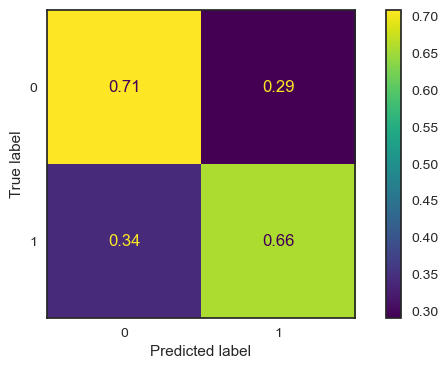

In [14]:
predictions = lgb_model.predict(X_val)
cm = confusion_matrix(y_val, predictions, labels=lgb_model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb_model.classes_)
disp.plot()

plt.show()

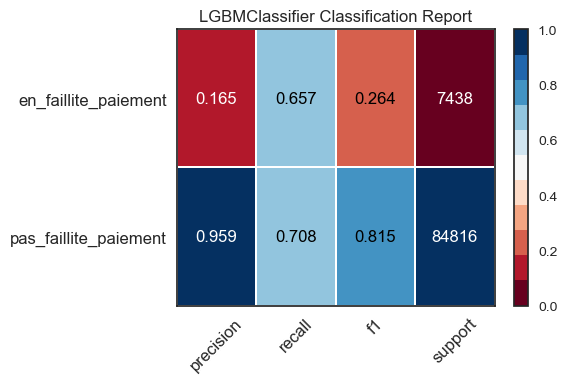

<Axes: title={'center': 'LGBMClassifier Classification Report'}>

In [15]:
# Identifying classes. 
classes = ['pas_faillite_paiement', 'en_faillite_paiement']

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(lgb_model, classes=classes, support=True, cmap='RdBu')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure


In [16]:
print(f"Train Accuracy : {accuracy_score(y_train, lgb_model.predict(X_train)):.2%}")
print(f"Test Accuracy : {accuracy_score(y_val, y_pred):.2%}")

Train Accuracy : 71.46%
Test Accuracy : 70.41%


In [17]:
print(f"Train Precision : {precision_score(y_train, lgb_model.predict(X_train)):.2%}")
print(f"Test Precision : {precision_score(y_val, y_pred):.2%}")

Train Precision : 18.12%
Test Precision : 16.48%


In [18]:
print(f"Train Recall : {recall_score(y_train, lgb_model.predict(X_train)):.2%}")
print(f"Test Recall : {recall_score(y_val, y_pred):.2%}")

Train Recall : 72.01%
Test Recall : 65.68%


In [19]:
print(f"Train f1_score : {f1_score(y_train, lgb_model.predict(X_train)):.2%}")
print(f"Test f1_score : {f1_score(y_val, y_pred):.2%}")

Train f1_score : 28.95%
Test f1_score : 26.35%


In [20]:
print(f"Train f2_score : {fbeta_score(y_train, lgb_model.predict(X_train), beta=2):.2%}")
print(f"Test f2_score : {fbeta_score(y_val, y_pred, beta=2):.2%}")

Train f2_score : 45.15%
Test f2_score : 41.13%


In [21]:
print(f"Train ROC-AUC : {roc_auc_score(y_train, lgb_model.predict(X_train)):.2%}")
print(f"Test ROC-AUC : {roc_auc_score(y_val, y_pred):.2%}")

Train ROC-AUC : 71.71%
Test ROC-AUC : 68.25%


In [22]:
from joblib import dump, load
dump(lgb_model, 'lgb_model_saved.joblib')

['lgb_model_saved.joblib']

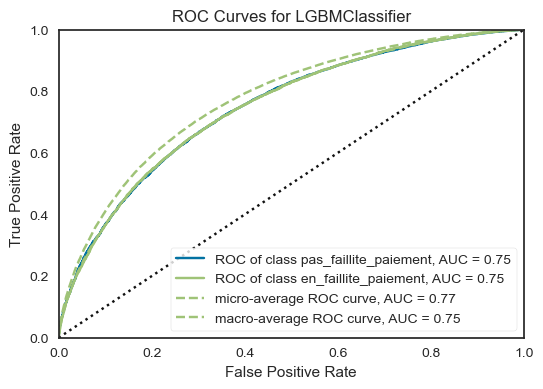

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [23]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

viz_rocauc = ROCAUC(lgb_model, classes=classes, random_state=1234)

viz_rocauc.fit(X_train, y_train)        
viz_rocauc.score(X_val, y_val)
viz_rocauc.show()          

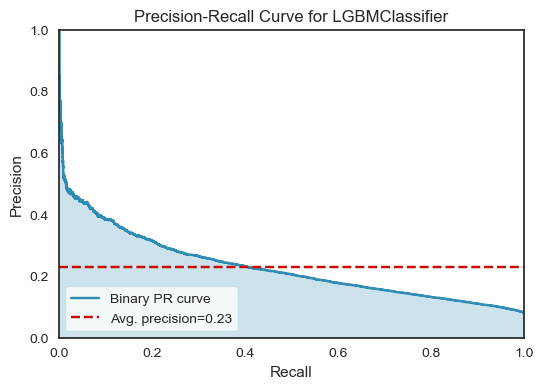

<Axes: title={'center': 'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [24]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

vis_prc = PrecisionRecallCurve(lgb_model, random_state=101)

vis_prc.fit(X_train, y_train)        
vis_prc.score(X_val, y_val)     
vis_prc.show()  